# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__  
__Выполнил: Шляпин Александр (4-сложная)__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
#x = np.random.normal(loc=5, scale=3, size=1000)
#(x**2).mean()

33.966629327520025

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
#d = 10
#X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
#(X**2).sum(axis=1).mean()

20.187783298433153

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [26]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков
linspace = linspace[:, np.newaxis]

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [30]:
from sklearn.tree import DecisionTreeRegressor
#import matplotlib.pyplot as plt

In [31]:
def picture(method, n_samples, deep_max):
    av_predictions = []
    for i in range(n_samples):
        X_raw = np.random.exponential(scale=1.0, size=sample_size)
        y_raw = f(X_raw)
        noize = np.random.uniform(low=-1.0, high=1.0, size=sample_size)
        y = y_raw + noize
        X = X_raw[:, np.newaxis]
        model = method(random_state=0, max_depth = deep_max)
        model.fit(X, y)
        predictions = model.predict(linspace)
        if i == 0:
            av_predictions = model.predict(linspace)
        else:
            av_predictions += predictions
        plt.plot(predictions, color="gray", alpha=0.5)
    av_prediction = av_predictions / n_samples
    plt.plot(av_prediction, color="black")
    plt.plot(f(linspace), color="red")
    plt.show()

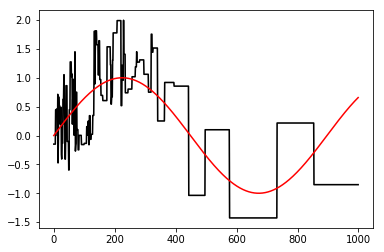

In [32]:
picture(DecisionTreeRegressor, 1, None)

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

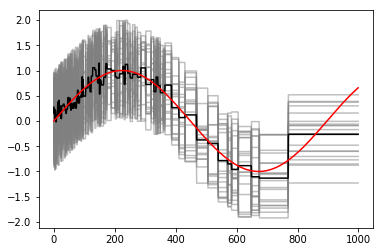

In [65]:
picture(DecisionTreeRegressor, samples_num, None)

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

For max_depth = 2:


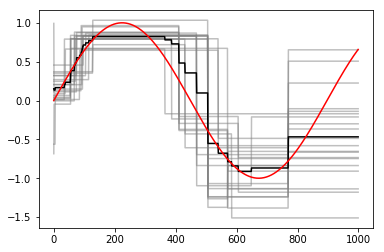

For max_depth = 4:


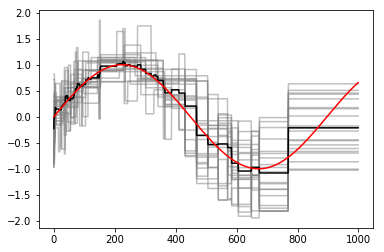

In [68]:
print("For max_depth = 2:")
picture(DecisionTreeRegressor, samples_num, 2)
print("For max_depth = 4:")
picture(DecisionTreeRegressor, samples_num, 4)

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

По картинкам можно сказать, что смещение решающего дерева больше всего близко к нулю в случае максимальной глубины дерева = 4, на втором месте стоит случай без ограничения на глубину дерева, и смещение максимально в случае максимальной глубины дерева = 2.  
Возможно, это происходит из-за следующего: при максимальной глубине = 2 модель недообучается, при случае без ограничения на глубину дерева, модель переобучается, а модель с максимальной глубиной = 4 является золотой серединой, при которой достигается наилучшее качество модели.

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

For linear regression:


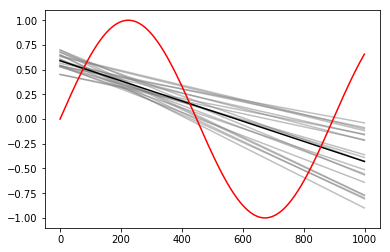

In [75]:
from sklearn.linear_model import LinearRegression
def picture2(method, n_samples):
    av_predictions = []
    for i in range(n_samples):
        X_raw = np.random.exponential(scale=1.0, size=sample_size)
        y_raw = f(X_raw)
        noize = np.random.uniform(low=-1.0, high=1.0, size=sample_size)
        y = y_raw + noize
        X = X_raw[:, np.newaxis]
        model = method()
        model.fit(X, y)
        predictions = model.predict(linspace)
        if i == 0:
            av_predictions = model.predict(linspace)
        else:
            av_predictions += predictions
        plt.plot(predictions, color="gray", alpha=0.5)
    av_prediction = av_predictions / n_samples
    plt.plot(av_prediction, color="black")
    plt.plot(f(linspace), color="red")
    plt.show()
print("For linear regression:")
picture2(LinearRegression, samples_num)

For SVM (rbf), gamma = 1:


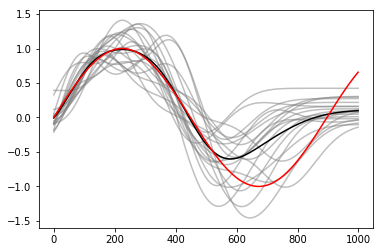

In [34]:
from sklearn.svm import SVR
def picture3(method, n_samples, gamma):
    av_predictions = []
    for i in range(n_samples):
        X_raw = np.random.exponential(scale=1.0, size=sample_size)
        y_raw = f(X_raw)
        noize = np.random.uniform(low=-1.0, high=1.0, size=sample_size)
        y =  y_raw + noize
        #for j in range(len(y)):
        #    y[j] = round(y[j])
        X = X_raw[:, np.newaxis]
        model = method(gamma = gamma, kernel = 'rbf')
        model.fit(X, y)
        predictions = model.predict(linspace)
        if i == 0:
            av_predictions = model.predict(linspace)
        else:
            av_predictions += predictions
        plt.plot(predictions, color="gray", alpha=0.5)
    av_prediction = av_predictions / n_samples
    plt.plot(av_prediction, color="black")
    plt.plot(f(linspace), color="red")
    plt.show()
print("For SVM (rbf), gamma = 1:")
picture3(SVR, samples_num, 1)

For SVM (rbf), gamma = 100:


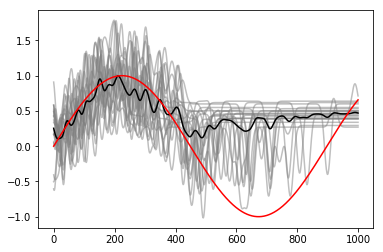

In [36]:
print("For SVM (rbf), gamma = 100:")
picture3(SVR, samples_num, 100)

Линейная модель плохо применима для данной задачи. Если сравнивать SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$, то с задачей лучше справилась модель с $\gamma = 1$.  
Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’ (Интуитивно, параметр гамма опредяет, как сильно влияет один один training example. Маленькое значение означает, что сильно влияет, высокое значение означает слабое влияние).  
Модель с большим гамма оказалась слошком чувствительно (и сложной), чтобы аппроксимировать зависимость, в отличии от модели с малой гаммой.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.



In [2]:
import pandas as pd
mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header = None)
tic = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', header = None)
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header = None)
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header = None)

In [3]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [ ]:
#mushrooms = mushrooms.replace('close', '1')
#mushrooms = mushrooms.replace('crowded', '2')
#mushrooms = mushrooms.replace('distant', '3')
'''mushrooms = mushrooms.replace('pre', 'post')
mushrooms = mushrooms.replace('pre', 'post')
mushrooms = mushrooms.replace('pre', 'post')
mushrooms = mushrooms.replace('pre', 'post')
'''

In [ ]:
mushrooms.iloc[0][7]

Для mushroom, tic-tac-toe, cars, nursery по порядку указаны accuracy DecisionTreeClassifier, считающий все признаки вещественными, DecisionTreeClassfier, считающий все признаки категориальными, DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки (если есть вещественные признаки) по порядку.  
Для mushroom правильные вещественные признаки (по моему мнению): gill-spacing, ring-number, population  
Для tic-tac-toe правильные вещественные признаки: нет 
Для cars правильные вещественные признаки: все 
Для nursery правильные вещественные признаки: все  
Каждый признак, который должен быть вещественным, я перевожу в вещественный так, чтобы порядок сохранялся (чтобы вместо того порядка, который должен быть, не применялся порядок по алфавиту).  
Когда один из признаков численных переменных был 'more', я переводил его в вещественное число, так как одна из эвристик говорит, что результаты сещественно не должны измениться.

In [54]:
def accuracy_estimation(raw_df, index_of_y, indexes_of_real_numbers, special_conditions):
    df = raw_df.copy(deep=True)
    if special_conditions is not None:
        for j in range(len(df.columns)):
            for i in range(len(df.index)):
                if df.iloc[i][j] in special_conditions:
                    df.loc[i][j] = special_conditions[df.iloc[i][j]]
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index(index_of_y)))
    df = df[cols]
    
    list_of_indexes = []
    for i in range(len(df.columns)):
        list_of_indexes.append(i)
    df.columns = list_of_indexes
    
    
    df.loc[:, :] = df.iloc[:, :].apply(LabelEncoder().fit_transform)
    list_of_indexes_of_X = []
    for i in range(len(df.columns)):
        if i != 0:
            list_of_indexes_of_X.append(i)
    print(np.mean(cross_val_score(X=df.iloc[:, 1:], y=df.iloc[:, 0], estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score))))        
    
    df2 = df.copy(deep=True)
    df2 = pd.get_dummies(df2, columns = list_of_indexes_of_X)

    print(np.mean(cross_val_score(X=df2.iloc[:, 1:], y=df2.iloc[:, 0], estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score))))
    
    if len(indexes_of_real_numbers) > 0:
        df3 = df.copy(deep=True)
        list_of_indexes_of_X = []
        for i in range(len(df.columns)):
            if i != 0 and ((i in indexes_of_real_numbers) is False):
                list_of_indexes_of_X.append(i)
        df3 = pd.get_dummies(df3, columns = list_of_indexes_of_X)
        print(np.mean(cross_val_score(X=df3.iloc[:, 1:], y=df3.iloc[:, 0], estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score))))


In [57]:
accuracy_estimation(mushrooms, 0, [7, 18, 21], {'c':"2",
                                                'w':'3',
                                                'd':'4',
                                                'n':'3',
                                                'o':'4',
                                                't':'5',
                                                'a':'1',
                                                's':'4',
                                                'v':'5',
                                                'y':'6'})

0.965552375622
0.956428444679
0.968265682657


In [58]:
accuracy_estimation(tic, 9, [], None)

0.753233179598
0.83749321758


In [61]:
accuracy_estimation(cars, 6, [1, 2, 3, 4, 5, 6], {"unacc":'0', "acc":'0', "good":'1', "vgood":'1', 'v-high':'4', 'high':'3', 'med':'2', 'low':'1', '5-more':'5', 'more':'5', 'small':'1', 'big':'3'}) 

0.875781876504
0.826931301791
0.875781876504


In [68]:
accuracy_estimation(nursery, 8, [1, 2, 3, 4, 5, 6, 7, 8], {'not_recom':'0', 'recommend':'0', "very_recom":'1', "priority":'1',
                                                           "spec_prior":'1','usual':'1',
                                                           'pretentious':'2',
                                                           'great_pret':'3','proper':'1', 'less_proper':'2', 'improper':'3', 'critical':'4', 'very_crit':'5','complete':'1', 'completed':'2', 'incomplete':'3', 'foster':'4','more':'4','convenient':'2', 'less_conv':'3', 'critical':'4','convenient':'2', 'inconv':'3', 'non-prob':'1', 'slightly_prob':'2', 'problematic':'3'})

0.999691477008
0.999691477008
0.999691477008


__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Если большинство признаков вещественные по своей сути, то алгоритм, считающий все признаки вещественными работает лучше, чем алгоритм, считающий все признаки категориальными.  
Если большинство признаков категориальные по своей сути, то алгоритм, считающий все признаки категориальными работает лучше, чем алгорит, считающий все признаки вещественными.
Если часть признаков вещественные по своей сути, а часть категориальные по своей сути, то разбив их соответствующим образом, мы получили accuracy выше, чем в двух других (если бы считать все признаки либо категориальными, либо вещественными).  
Почему так происходит? 
Мне сложно понять, что от меня требуется в ответе на задание: "Порассуждайте, почему так происходит", но я напишу в ответе очевидную вещь: если признак по своей сути вещественный, то дав алгоритму понять, что это вещественный признак, мы улучшаем его качество, так как он будет применять методы, оптимальные именно для вещественных признаков. То же самое с категориальными признаками.


Про элемент случайности (ниже есть вариант на английском):  
Элемент случайности (дисперсии) присутствует.
Существует два источника дисперсии. Первая - это случайность самой процедуры; это можно уменьшить, увеличив количество деревьев.

Другим источником различий является неприводимое несовершенство наличия ограниченных данных и жизни в сложном мире. Увеличение количества деревьев не может исправить это.
(Оба источника присутствуют в модели)

Кроме того, иногда для решения проблемы недостаточно данных. Например, представьте, что два экземпляра имеют противоположные метки, но идентичные значения признаков. Один из этих образцов всегда будет ошибочно классифицирован. (Это экстремальный пример, но иллюстрирует, как некоторые проблемы не могут быть исправлены. Мы можем немного его смягчить, рассматривая крошечное возмущение для одного вектора, теперь оно будет * обычно * классифицироваться так же, как его близнец, но не всегда.) Чтобы решить эта проблема, вам придется собирать дополнительные измерения, чтобы еще больше отличить две точки.

Однако увеличение количества деревьев может уменьшить * дисперсию оценки * чего-то вроде $p(y=1|x)$. Рассмотрим результаты из центральной предельной теоремы: увеличение размера выборки может уменьшить дисперсию статистики как среднее, но не устранить ее. Случайные предсказания леса представляют собой средние $\bar{x}$ всех предсказаний деревьев, и эти предсказания сами по себе являются случайными величинами (из-за начальной загрузки и случайного подмножества признаков, причем оба происходят независимо, поэтому голоса также являются iid). CLT обеспечивает, что $\bar{x} $ приближается к нормальному распределению $\bar{x}\sim\mathcal{N}(\mu,\frac{\sigma^2}{n})$, где $ \ mu $ - истинное среднее предсказание, а $ \ sigma ^ 2 $ - дисперсия голосов деревьев. (Голоса принимают значения либо 0, либо 1, поэтому среднее число голосов имеет конечную дисперсию.) Дело в том, что ** удвоение количества деревьев сократит дисперсию $\bar{x}$ пополам, t приводят его к нулю. ** (За исключением случаев, когда $ \ sigma ^ 2 = 0 $, но мы знаем, что здесь не так).

Невоспроизводимая дисперсия не может быть исправлена ​​при начальной загрузке. Более того, случайные леса уже загружены; это часть причины, по которой он имеет «случайный» от своего имени. (Другая причина заключается в том, что на каждом расколе выбирается случайное подмножество признаков).

There are two sources of the OOB variance. One is the randomness of the procedure itself; this can be reduced by increasing the number of trees. 

The other source of variance is the irreducible imperfection of having limited data and living in a complex world. Increasing the number of trees can't fix this. 

Additionally, sometimes there just isn't enough data to solve the problem. For example, imagine two instances have the opposite labels but identical feature values. One of these samples will always be misclassified. (This is an extreme example, but illustrates how some problems are unfixable. We can relax it somewhat by considering a tiny perturbation to one vector; now it will *usually* be classified the same as its twin, but not always.) To solve this problem, you'd have to collect additional measurements to further distinguish the two points.

Increasing the number of trees can reduce the *variance of the estimate* of something like $p(y=1|x)$, though. Consider the results from the central limit theorem: increasing the sample size can reduce variance of a statistic like an average, but not eliminate it. The random forest predictions are an average $\bar{x}$ of all the trees' predictions, and these predictions are themselves random variables (because of the bootstrapping and random subsetting of features; both happen independently, so votes are also iid). The CLT provides that $\bar{x}$ approaches a normal distribution $\bar{x}\sim\mathcal{N}(\mu,\frac{\sigma^2}{n})$, where $\mu$ is the true mean prediction and $\sigma^2$ is the variance of the trees' votes. (Votes take values of either 0 or 1, so an average of the votes has finite variance.) The point is that **doubling the number of trees will cut the variance of $\bar{x}$ in half, but won't drive it to zero.** (Except when $\sigma^2=0$, but we know that is not the case here.) 

Irreducible variance can't be fixed by bootstrapping. Moreover, random forests are already bootstrapped; it's part of the reason that it has "random" in its name. (The other reason being that a random subset of features are selected at each split.)


### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [5]:
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep = ";")

In [6]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [32]:
np.mean(cross_val_score(X=wine.iloc[:, :11], y=wine.iloc[:, -1], estimator=DecisionTreeClassifier(), cv=3, scoring=make_scorer(accuracy_score))) 

0.45531943657298618

In [33]:
np.mean(cross_val_score(X=wine.iloc[:, :11], y=wine.iloc[:, -1], estimator=BaggingClassifier(n_estimators = 100), cv=3, scoring=make_scorer(accuracy_score)))

0.5560198309785882

In [34]:
np.mean(cross_val_score(X=wine.iloc[:, :11], y=wine.iloc[:, -1], estimator=BaggingClassifier(n_estimators = 100, max_features = 0.5), cv=3, scoring=make_scorer(accuracy_score)))

0.55538037742779789

In [35]:
np.mean(cross_val_score(X=wine.iloc[:, :11], y=wine.iloc[:, -1], estimator=RandomForestClassifier(n_estimators = 100), cv=3, scoring=make_scorer(accuracy_score)))

0.56481297387596041

#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [36]:
X_train, X_test, y_train, y_test = train_test_split(wine.iloc[:, :11], wine.iloc[:, -1], test_size=0.3, random_state=42, shuffle = True)

In [59]:
model = RandomForestClassifier(n_estimators = 100, warm_start=True)
model.fit(X_train, y_train)
df = pd.DataFrame(columns=['Numbers_of_trees', 'Accuracy'])

numbers_of_trees = []
for i in range(100, 5001, 100):
    numbers_of_trees.append(i)
#print(numbers_of_trees)

for i in range(len(numbers_of_trees)):
    test_model = model.set_params(n_estimators = numbers_of_trees[i])
    test_model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #df_temp = pd.DataFrame(numbers_of_trees[i], accuracy, columns=['Numbers_of_trees', 'Accuracy'])
    df_raw = {'Numbers_of_trees': [numbers_of_trees[i]], 'Accuracy': [accuracy]}
    df_temp = pd.DataFrame(data=df_raw)
    df = df.append(df_temp, ignore_index=True)
    
df.head()

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:304: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


,Accuracy,Numbers_of_trees
0,0.668750,100
1,0.658333,200
2,0.664583,300
3,0.660417,400
4,0.656250,500


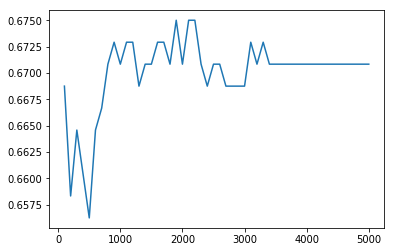

In [60]:
plt.plot(df.iloc[:,1], df.iloc[:,0])

Случайный лес с увеличением количества деревьев переобучается. В нашем примеры переобучение пошло примерно после 2100 деревьев.

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [125]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist

In [179]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [1]:
import numpy as np
np.random.seed(1337) # for reproducibility

import os
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.utils import np_utils

batch_size = 32 #Number of images used in each optimization step
nb_classes = 10 #One class per digit
nb_epoch = 5 #Number of times the whole data is used to learn

(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Flatten the data, MLP doesn't use the 2D structure of the data. 784 = 28*28
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

#Make the value floats in [0;1] instead of int in [0;255]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

#Display the shapes to check if everything's ok
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices (ie one-hot vectors)
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#Define the model achitecture
model = Sequential()
model.add(Dense(100, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(10)) #Last layer with one output per class
model.add(Activation('softmax')) #We want a score simlar to a probability for each class

#Use rmsprop to do the gradient descent 
rms = RMSprop()
#The function to optimize is the cross entropy between the true label and the output (softmax) of the model
model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=["accuracy"])

#Make the model learn
model.fit(X_train, Y_train,
batch_size=batch_size, epochs=nb_epoch,
verbose=2,
validation_data=(X_test, Y_test))

#Evaluate how the model does on the test set
score = model.evaluate(X_test, Y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 12s - loss: 0.2459 - acc: 0.9293 - val_loss: 0.1341 - val_acc: 0.9599
Epoch 2/5
 - 10s - loss: 0.1130 - acc: 0.9670 - val_loss: 0.1031 - val_acc: 0.9698
Epoch 3/5
 - 10s - loss: 0.0830 - acc: 0.9758 - val_loss: 0.1014 - val_acc: 0.9706
Epoch 4/5
 - 11s - loss: 0.0668 - acc: 0.9810 - val_loss: 0.1130 - val_acc: 0.9713
Epoch 5/5
 - 11s - loss: 0.0576 - acc: 0.9840 - val_loss: 0.1150 - val_acc: 0.9738
Test score: 0.115001247149
Test accuracy: 0.9738


__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [37]:
# Larger CNN for the MNIST Dataset
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
# define the larger model
def larger_model():
# create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation='relu', input_shape=(1, 28, 28)))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))


    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# build the model
model = larger_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=16, batch_size=200)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)

Train on 60000 samples, validate on 10000 samples
Epoch 1/16
60000/60000 [==============================] - 267s 4ms/step - loss: 0.3726 - acc: 0.8882 - val_loss: 0.1024 - val_acc: 0.9680
Epoch 2/16
60000/60000 [==============================] - 266s 4ms/step - loss: 0.0927 - acc: 0.9716 - val_loss: 0.0618 - val_acc: 0.9793
Epoch 3/16
60000/60000 [==============================] - 262s 4ms/step - loss: 0.0628 - acc: 0.9807 - val_loss: 0.0664 - val_acc: 0.9795
Epoch 4/16
60000/60000 [==============================] - 288s 5ms/step - loss: 0.0516 - acc: 0.9841 - val_loss: 0.0376 - val_acc: 0.9882
Epoch 5/16
60000/60000 [==============================] - 293s 5ms/step - loss: 0.0419 - acc: 0.9873 - val_loss: 0.0484 - val_acc: 0.9833
Epoch 6/16
60000/60000 [==============================] - 298s 5ms/step - loss: 0.0379 - acc: 0.9882 - val_loss: 0.0344 - val_acc: 0.9886
Epoch 7/16
60000/60000 [==============================] - 296s 5ms/step - loss: 0.0312 - acc: 0.9902 - val_loss: 0.0304 - 

Accuracy данной модели: 0.991

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [38]:
# Larger CNN for the MNIST Dataset
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
# define the larger model
def larger_model():
# create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation='relu', input_shape=(1, 28, 28)))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))


    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# build the model
model = larger_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=16, batch_size=200)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)

Train on 60000 samples, validate on 10000 samples
Epoch 1/16
60000/60000 [==============================] - 286s 5ms/step - loss: 0.3828 - acc: 0.8837 - val_loss: 0.0838 - val_acc: 0.9746
Epoch 2/16
60000/60000 [==============================] - 278s 5ms/step - loss: 0.0989 - acc: 0.9695 - val_loss: 0.0665 - val_acc: 0.9795
Epoch 3/16
60000/60000 [==============================] - 289s 5ms/step - loss: 0.0704 - acc: 0.9781 - val_loss: 0.0431 - val_acc: 0.9848
Epoch 4/16
60000/60000 [==============================] - 275s 5ms/step - loss: 0.0581 - acc: 0.9819 - val_loss: 0.0393 - val_acc: 0.9869
Epoch 5/16
60000/60000 [==============================] - 274s 5ms/step - loss: 0.0495 - acc: 0.9844 - val_loss: 0.0368 - val_acc: 0.9878
Epoch 6/16
60000/60000 [==============================] - 271s 5ms/step - loss: 0.0454 - acc: 0.9858 - val_loss: 0.0288 - val_acc: 0.9901
Epoch 7/16
60000/60000 [==============================] - 273s 5ms/step - loss: 0.0401 - acc: 0.9874 - val_loss: 0.0315 - 

Accuracy данной модели: 0.992. Это лучше, чем в модели без Dropout. Возможно, dropout снижает переобучение, и тем самым увеличивает качество модели.

Использованные источники:
https://elitedatascience.com/keras-tutorial-deep-learning-in-python#step-4  
https://stats.stackexchange.com/questions/269135/why-are-my-random-forest-results-so-variable  
https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/  
https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/  
http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html